In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np

%matplotlib inline

img = mpimg.imread('images/input/curved-lane.jpg')

In [15]:
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
S = hls[:,:,2]

thresh = (150, 255)
hls_bin = np.zeros_like(S)
hls_bin[(S > thresh[0]) & (S <= thresh[1])] = 1

R = img[:,:,0]
rgb_bin = np.zeros_like(R)
rgb_bin[(R > thresh[0]) & (R <= thresh[1])] = 1

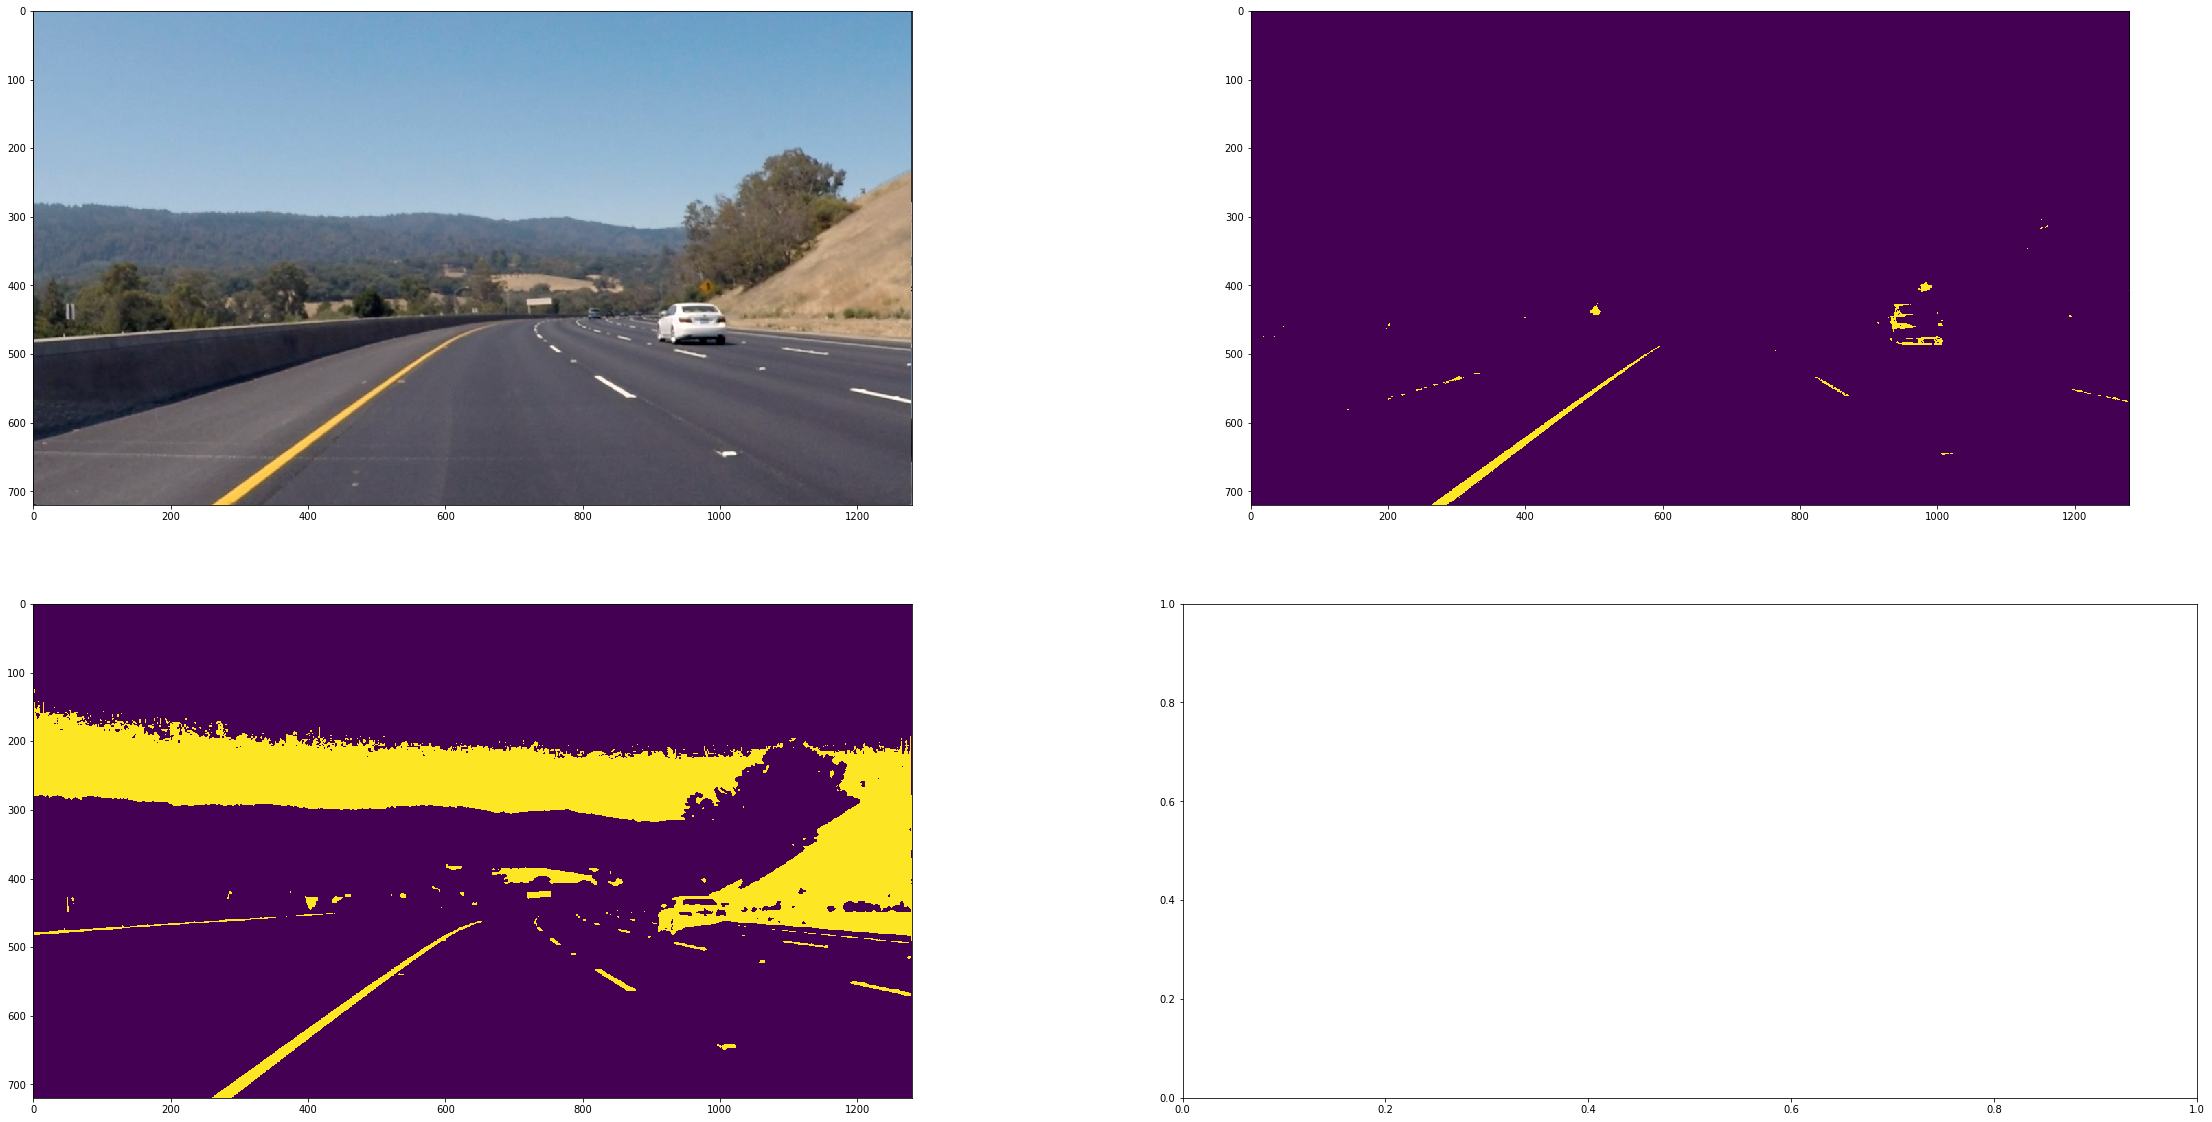

In [16]:
f, ax = plt.subplots(2,2, figsize=(40, 20))
ax[0,0].imshow(img)
ax[0,1].imshow(hls_bin)
ax[1,0].imshow(rgb_bin)

### The Path demarkated

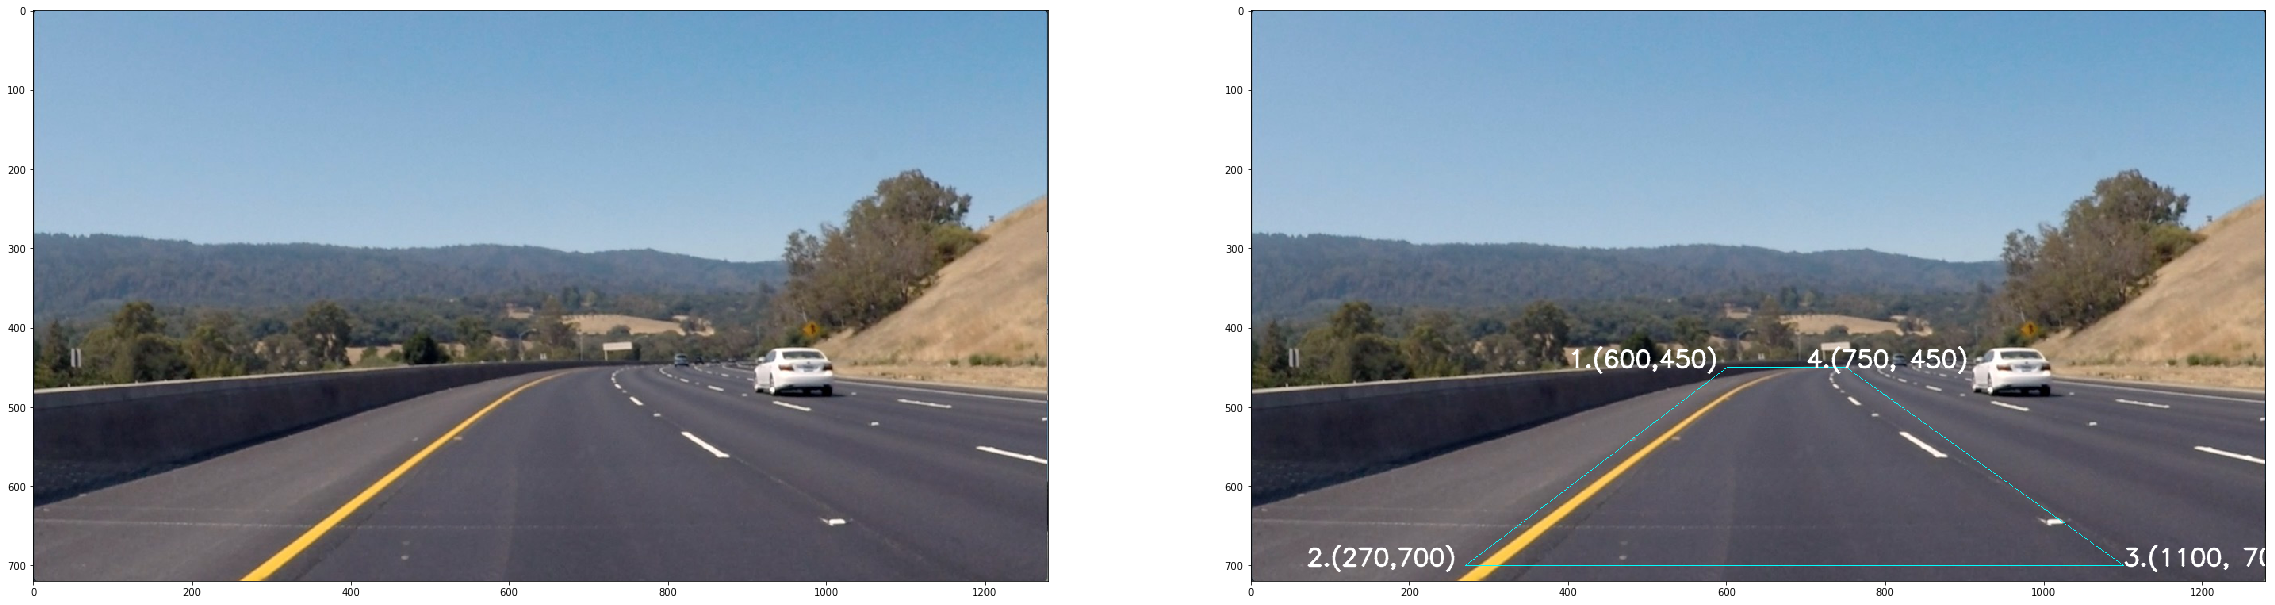

In [40]:
img_copy = np.copy(img)

#                (x1, y1), (x2, y2), (x3, y3), (x4, y4)
# http://docs.opencv.org/3.1.0/dc/da5/tutorial_py_drawing_functions.html
pts = np.array([[600, 450],[270, 700],[1100, 700],[750, 450]], np.int32)
pts = pts.reshape((-1,1,2))
cv2.polylines(img_copy,[pts],True,(0,255,255))

font = cv2.FONT_HERSHEY_SIMPLEX
font_color = (255,255,255)
cv2.putText(img_copy,'1.(600,450)',(400,450), font, 1,font_color,2,cv2.LINE_AA)
cv2.putText(img_copy,'2.(270,700)',(70, 700), font, 1,font_color,2,cv2.LINE_AA)
cv2.putText(img_copy,'3.(1100, 700)',(1100, 700), font, 1,font_color,2,cv2.LINE_AA)
cv2.putText(img_copy,'4.(750, 450)',(700, 450), font, 1,font_color,2,cv2.LINE_AA)

f, ax = plt.subplots(1,2, figsize=(40, 20))
ax[0].imshow(img)
ax[1].imshow(img_copy)

### Warp the image

In [51]:
def warp(img, src, dst):
    image_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(img, M, image_size, flags= cv2.INTER_LINEAR)

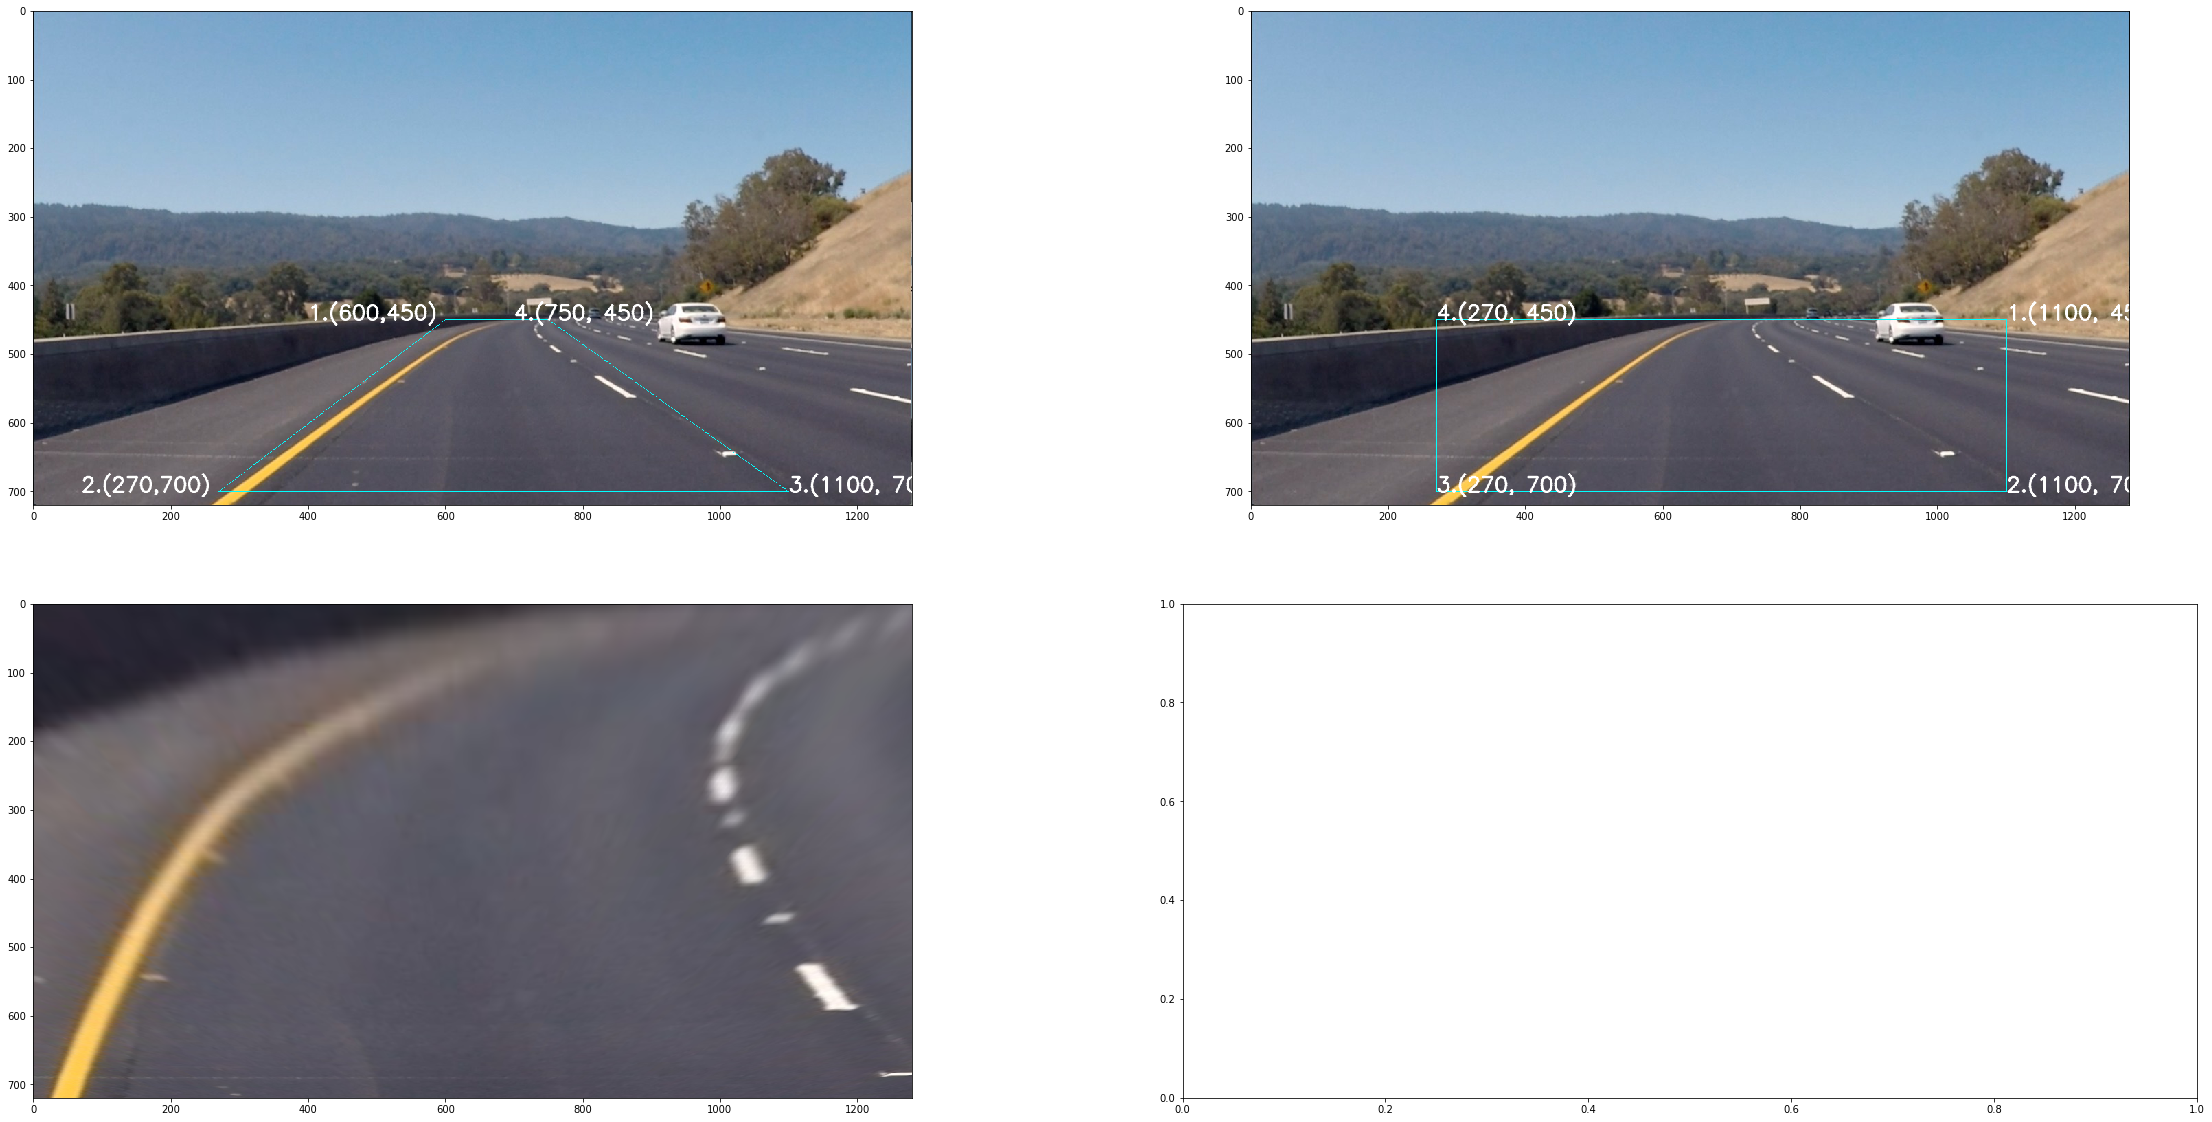

In [59]:
src = np.float32([[750, 450], [1100, 700], [270, 700], [600, 450]])
dst = np.float32([[img.shape[1], 0], [img.shape[1], img.shape[0]], [0, img.shape[0]], [0, 0]])

warped_img = warp(img, src, dst)

img_copy2 = np.copy(img)

#                (x1, y1), (x2, y2), (x3, y3), (x4, y4)
# http://docs.opencv.org/3.1.0/dc/da5/tutorial_py_drawing_functions.html
pts = np.array([(1100, 450), (1100, 700), (270, 700), (270, 450)], np.int32)
pts = pts.reshape((-1,1,2))

cv2.polylines(img_copy2,[pts],True,(0,255,255))
cv2.putText(img_copy2,'1.(1100, 450)',(1100, 450), font, 1,font_color,2,cv2.LINE_AA)
cv2.putText(img_copy2,'2.(1100, 700)',(1100, 700), font, 1,font_color,2,cv2.LINE_AA)
cv2.putText(img_copy2,'3.(270, 700)',(270, 700), font, 1,font_color,2,cv2.LINE_AA)
cv2.putText(img_copy2,'4.(270, 450)',(270, 450), font, 1,font_color,2,cv2.LINE_AA)

f, ax = plt.subplots(2,2, figsize=(40, 20))
ax[0,0].imshow(img_copy)
ax[0,1].imshow(img_copy2)
ax[1,0].imshow(warped_img)

# Warped road line in gray

In [63]:
warped_rgb_bin = warp(rgb_bin, src, dst)

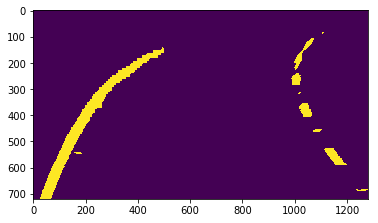

In [99]:
plt.imshow(warped_rgb_bin)

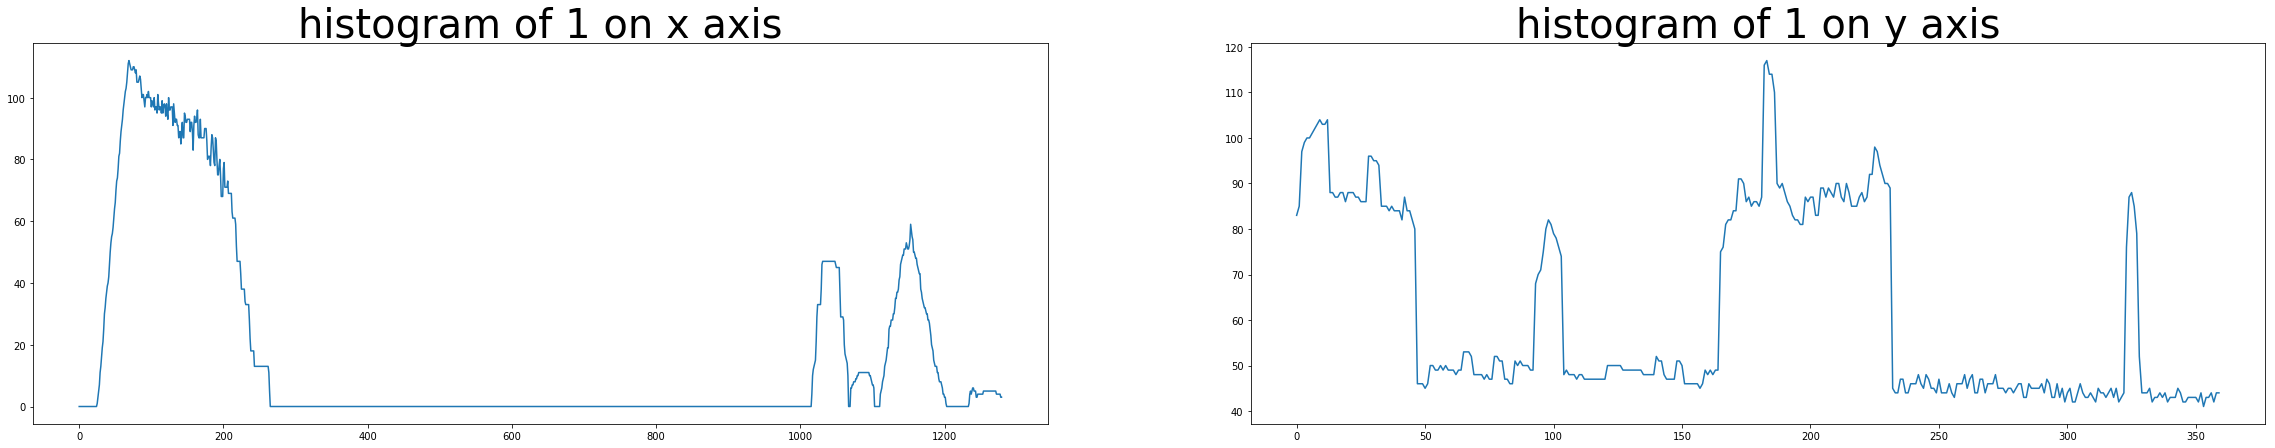

In [88]:
histogramx = np.sum(warped_rgb_bin[warped_rgb_bin.shape[0]//2:, :], axis=0)
histogramy = np.sum(warped_rgb_bin[warped_rgb_bin.shape[0]//2:, :], axis=1)

f, ax = plt.subplots(1,2, figsize=(40, 7))
ax[0].plot(histogramx)
ax[0].set_title("histogram of 1 on x axis", fontsize=40)
ax[1].plot(histogramy)
ax[1].set_title("histogram of 1 on y axis", fontsize=40)

### create a binary image to draw on

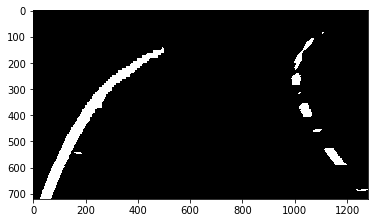

In [89]:
out_img = np.dstack((warped_rgb_bin, warped_rgb_bin, warped_rgb_bin)) * 255
plt.imshow(out_img)

In [97]:
print(histogramx)
midpoint = np.int(len(histogramx)/2)
leftx_base = np.argmax(histogramx[:midpoint])
rightx_base = np.argmax(histogramx[midpoint:]) + midpoint

print("midpoint: ", midpoint, "leftx_base: ", leftx_base, "rightx_base: ", rightx_base)

[0 0 0 ..., 4 3 3]
midpoint:  640 leftx_base:  69 rightx_base:  1153


In [102]:
nwindows = 9
window_height = np.int(warped_rgb_bin.shape[0]/nwindows)

(array([ 81,  81,  81, ..., 719, 719, 719]), array([1110, 1111, 1112, ...,   66,   67,   68]))


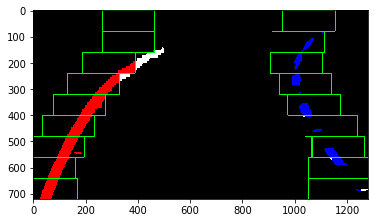

In [114]:
nonzero = warped_rgb_bin.nonzero()
print(nonzero)
nonzerox = nonzero[1]
nonzeroy = nonzero[0]

leftx_current = leftx_base
rightx_current = rightx_base

margin = 100
minpix = 50

left_lane_inds = []
right_lane_inds = []

for window in range(nwindows):
    win_y_low = warped_rgb_bin.shape[0] - (window+1)*window_height
    win_y_high = warped_rgb_bin.shape[0] - (window)*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
    
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
plt.imshow(out_img)

In [115]:
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

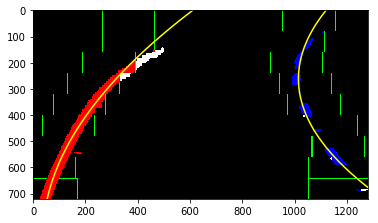

In [116]:
ploty = np.linspace(0, warped_rgb_bin.shape[0]-1, warped_rgb_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [117]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

TypeError: expected x and y to have same length